This file contains code for plotting 

- rank

- ncpts

- max dwell time 

- averge of max freq (imag part of eig)

In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN-AD")

In [2]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import os
import scipy.stats as ss
from scipy import signal
from tqdm import tqdm
import pickle
import seaborn as sns
import numbers
import scipy
import pandas as pd
import statsmodels.api as sm
%matplotlib inline

/home/huaqingj/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import importlib
import pyTVDN.utils
importlib.reload(pyTVDN.utils)
from pyTVDN.utils import load_pkl, save_pkl

In [4]:
os.chdir("/home/huaqingj/MyResearch/TVDN-AD/")
resDir = Path("./results")
dataDir = Path("./data")

## Load features

### Load data

In [5]:
with open("./OtherFils/KpIdxsAll.pkl", "rb") as sf:
    kpAD, kpCtrl, kpAll = pickle.load(sf)

In [6]:
# ecpts
fil = list(resDir.glob("AD_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssCtrl = pickle.load(f)

In [7]:
# Eigvals
fil = list(resDir.glob("AD_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsCtrl = pickle.load(f)

In [8]:
# Sel data (only need when use sub data)
ecptssAD = [ ecptsAD for ecptsAD, kpix in zip(ecptssAD, kpAD) if kpix==1]
ecptssCtrl = [ ecptsCtrl for ecptsCtrl, kpix in zip(ecptssCtrl, kpCtrl) if kpix==1]
eigValsAD = [ v for v, kpix in zip(eigValsAD, kpAD) if kpix==1]
eigValsCtrl = [ v for v, kpix in zip(eigValsCtrl, kpCtrl) if kpix==1]

### some fn

In [9]:
### The canonical networks
def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

def minmax_brainplotting(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den + 1e-3


In [10]:
def CI95(cur_fs):
    mean_v, se_v = np.mean(cur_fs), np.std(cur_fs)/np.sqrt(len(cur_fs))
    low, up = mean_v - 1.96*se_v, mean_v + 1.96*se_v
    return [low, up]

In [11]:
def tmp_plot_base(cur_fs_AD, cur_fs_Ctrl):
    cols = ["dodgerblue", "coral"]
    box = plt.boxplot(cur_fs_AD, positions=[0.4],
                      notch=True, showfliers=False,  patch_artist=True);
    for item in ['boxes', 'whiskers',  'medians', 'caps']:
    # set colors for all elements in boxplot
        plt.setp(box[item], color=cols[0])
    box1 = box
    
    box = plt.boxplot(cur_fs_Ctrl, positions=[0.6],
                      notch=True, showfliers=False,  patch_artist=True);
    for item in ['boxes', 'whiskers',  'medians', 'caps']:
        plt.setp(box[item], color=cols[1])
    box2 = box
    
    plt.xlim([0.3, 0.7])
    plt.xticks([0.4, 0.6], ["AD", "Control"])
    
def tmp_plot_bar(txty, bary, fs, pvalue, is_small=False):
    AD_fs, Ctrl_fs = fs

    txtxdlt = 0.1
    # left txt
    ix = 0.4
    #if is_small:
    #    txt1 = f"Mean: {np.mean(AD_fs):.2e} \n IQR [{np.quantile(AD_fs, 0.25):.2e}, {np.quantile(AD_fs, 0.75):.2e}]"
    #else:
    #    txt1 = f"Mean: {np.mean(AD_fs):.3f} \n IQR [{np.quantile(AD_fs, 0.25):.3f}, {np.quantile(AD_fs, 0.75):.3f}]"
    #plt.text(ix, txty, txt1, ha='center', va='bottom', color="k")
    
    # right txt
    ix = 0.6
    #if is_small:
    #    txt2 = f"Mean: {np.mean(Ctrl_fs):.2e} \n IQR [{np.quantile(Ctrl_fs, 0.25):.2e}, {np.quantile(Ctrl_fs, 0.75):.2e}]"
    #else:
    #    txt2 = f"Mean: {np.mean(Ctrl_fs):.3f} \n IQR [{np.quantile(Ctrl_fs, 0.25):.3f}, {np.quantile(Ctrl_fs, 0.75):.3f}]"
    #plt.text(ix, txty, txt2, ha='center', va='bottom', color="k")
    
    # bar and txt above
    ix = 0.5
    txtxdlt = 0.1
    txtx1, txtx2 = ix-txtxdlt, ix+txtxdlt
    #txth = 0.3
    
    all_dat = np.concatenate([AD_fs, Ctrl_fs])
    txth = (np.quantile(all_dat, 0.75) - np.quantile(all_dat, 0.25))/5
    txth1 = (np.quantile(all_dat, 0.75) - np.quantile(all_dat, 0.25))/10
    plt.plot([txtx1, txtx1, txtx2, txtx2], [bary, bary+txth, bary+txth, bary], lw=1.5, c="k")
    txt1 = f"P-value: {pvalue:.3f}"
    plt.text(ix, bary+txth+txth1, txt1, ha='center', va='bottom', color="k")

In [58]:
def tmp_errbar_boxplot(cen_pt, err_v, x_v, col, box_len=None):
    if box_len is None:
        box_len = err_v/2
    plt.fill_between(x=[x_v-0.03, x_v+0.03], 
                     y1=[cen_pt-box_len, cen_pt-box_len], 
                     y2=[cen_pt+box_len, cen_pt+box_len],
                     color=col, alpha=1)
    plt.errorbar(x=x_v, y=cen_pt, yerr=err_v, fmt='', color=col, capsize=10, elinewidth=2, capthick=2)
    plt.plot(x_v, cen_pt, marker='h', color="black")

def tmp_errbar_boxplot_wrap(fs_AD, fs_Ctrl, box_len=None):
    cols = ["dodgerblue", "coral"]
    mean_AD, se_AD = np.mean(fs_AD), np.std(fs_AD)/np.sqrt(len(fs_AD))
    mean_Ctrl, se_Ctrl = np.mean(fs_Ctrl), np.std(fs_Ctrl)/np.sqrt(len(fs_Ctrl))
    if box_len is None:
        box_len = (se_AD+se_Ctrl)/2
    tmp_errbar_boxplot(mean_AD, 1.96*se_AD, 0.4, cols[0], box_len)
    tmp_errbar_boxplot(mean_Ctrl, 1.96*se_Ctrl, 0.6, cols[1], box_len)
    plt.xlim([0.3, 0.7])
    plt.xticks([0.4, 0.6], ["AD", "Control"], fontsize=18)
    
    
def tmp_plot_bar2(fs, pvalue, ylim_fcts=[0.2, 0.5], is_small=False):
    AD_fs, Ctrl_fs = fs
    AD_CI, Ctrl_CI = CI95(AD_fs), CI95(Ctrl_fs)
    
    ylow_fct, yup_fct = ylim_fcts
    minv, maxv = np.min(AD_CI+Ctrl_CI), np.max(AD_CI+Ctrl_CI)
    vrange = maxv - minv
    ylow, yup = minv-ylow_fct*vrange, maxv+yup_fct*vrange
    box_len = 0.06*(yup-ylow)

    ## left txt
    #ix = 0.4
    #if is_small:
    #    txt1 = f"Mean: {np.mean(AD_fs):.2e} \n CI [{AD_CI[0]:.2e}, {AD_CI[1]:.2e}]"
    #    plt.text(ix, txty, txt1, ha='center', va='bottom', color="k", fontsize=12)
    #else:
    #    txt1 = f"Mean: {np.mean(AD_fs):.3f} \n CI [{AD_CI[0]:.3f}, {AD_CI[1]:.3f}]"
    #    #plt.text(ix, txty, txt1, ha='center', va='bottom', color="k", fontsize=12)
    #
    ## right txt
    #ix = 0.6
    #if is_small:
    #    txt2 = f"Mean: {np.mean(Ctrl_fs):.2e} \n CI [{Ctrl_CI[0]:.2e}, {Ctrl_CI[1]:.2e}]"
    #    plt.text(ix, txty, txt2, ha='center', va='bottom', color="k", fontsize=12)
    #else:
    #    txt2 = f"Mean: {np.mean(Ctrl_fs):.3f} \n CI [{Ctrl_CI[0]:.3f}, {Ctrl_CI[1]:.3f}]"
    #    #plt.text(ix, txty, txt2, ha='center', va='bottom', color="k", fontsize=12)
    
    # bar and txt above
    ix = 0.5
    txtxdlt = 0.1
    txtx1, txtx2 = ix-txtxdlt, ix+txtxdlt
    
    txth = vrange*0.05
    txth1 = vrange*0.05
    bary = yup-0.30*vrange
    plt.plot([txtx1, txtx1, txtx2, txtx2], [bary, bary+txth, bary+txth, bary], lw=1.5, c="k")
    
    if pvalue < 0.001:
        txt1 = f"P-value < 0.001"
        #txt1 = f"P-value$\\bf < 0.001$"
    elif pvalue <=0.05:
        txt1 = f"P-value: {pvalue:.3f}"
        #txt1 = f"P-value: $\\bf {pvalue:.3f}$"
    else: 
        txt1 = f"P-value: {pvalue:.3f}"
    plt.text(ix, bary+txth+txth1, txt1, ha='center', va='bottom', color="k", fontsize=18)
    plt.ylim([ylow, yup])
    return box_len

### The basic data transformation 

In [13]:
# Dwell times in second
freq = 120
dwellsAD = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssAD]
dwellsCtrl = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssCtrl]

In [14]:
ecptss = ecptssAD
dwells = dwellsAD
eigVals = eigValsAD

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.dwell = dwell 
    fs.ncpts = len(ecptss[i])
    fs.maxDwell = np.max(dwell)
    
    eigVal = eigVals[i]
    fs.eigVal = eigVal
    fs.absEigValMean = np.abs(eigVal).mean()
    fs.absImagEigValMean = np.abs(np.array(eigVal).imag).mean()
    fs.absImagEigValSumMean = np.abs(np.array(eigVal).imag).sum(axis=1).mean() # sum over rank first
    fs.absImagEigValMaxMean = np.abs(np.array(eigVal).imag).max(axis=1).mean() # max over rank first
    
    fs.r  =  len(eigVal[0])
    
    fsAll.append(fs)
    
fsAD = fsAll    

In [15]:
ecptss = ecptssCtrl
dwells = dwellsCtrl
eigVals = eigValsCtrl

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.dwell = dwell 
    fs.ncpts = len(ecptss[i])
    fs.maxDwell = np.max(dwell)
    
    eigVal = eigVals[i]
    fs.eigVal = eigVal
    fs.absEigValMean = np.abs(eigVal).mean()
    fs.absImagEigValMean = np.abs(np.array(eigVal).imag).mean()
    fs.absImagEigValSumMean = np.abs(np.array(eigVal).imag).sum(axis=1).mean() # sum over rank first
    fs.absImagEigValMaxMean = np.abs(np.array(eigVal).imag).max(axis=1).mean() # max over rank first
    
    fs.r  =  len(eigVal[0])
    
    fsAll.append(fs)
    
fsCtrl = fsAll    

## Plot

### ncpts

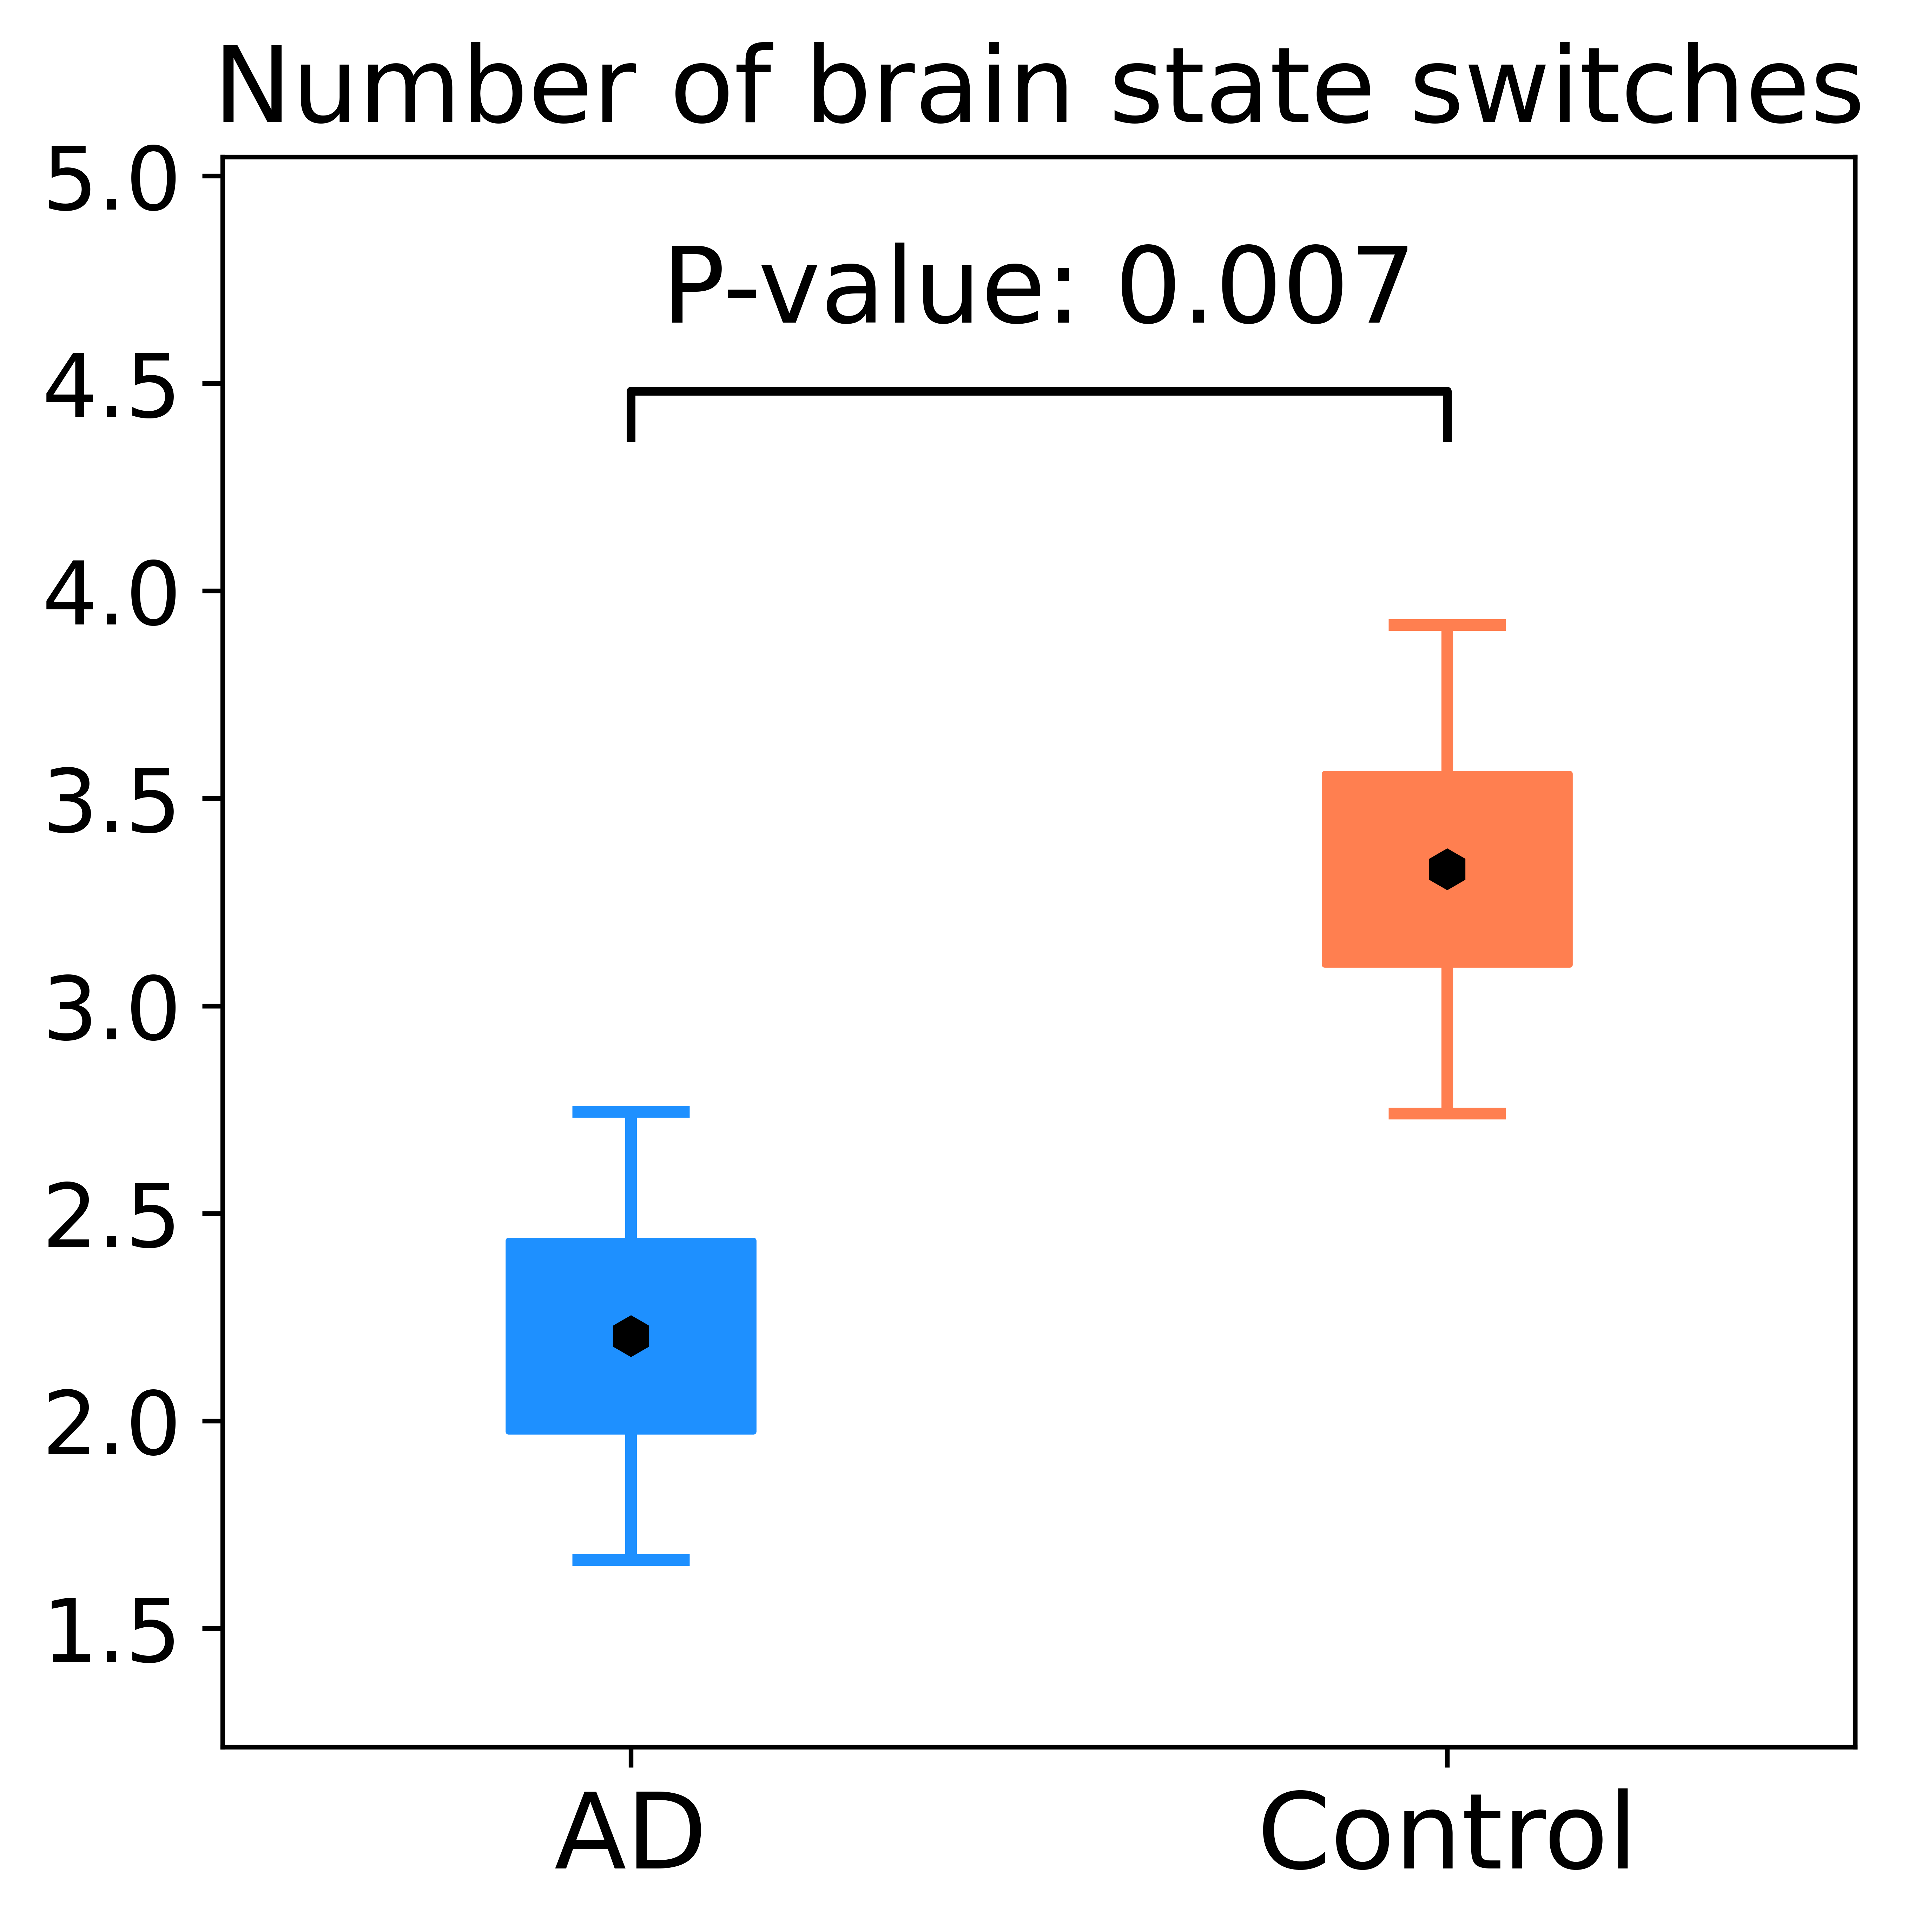

In [59]:
# ncpts
nchgsAD = [fs.ncpts for fs in fsAD]
nchgsCtrl = [fs.ncpts for fs in fsCtrl]

plt.figure(figsize=[5, 5], dpi=1200)
res = scipy.stats.ttest_ind(nchgsAD, nchgsCtrl, equal_var=False)
box_len = tmp_plot_bar2(fs=[nchgsAD, nchgsCtrl], pvalue=res.pvalue)
tmp_errbar_boxplot_wrap(nchgsAD, nchgsCtrl, box_len)
plt.yticks(fontsize=15)
plt.title("Number of brain state switches", fontsize=18)

plt.savefig("./plots/errbarplot_switching_pts.jpg", bbox_inches='tight')

In [ ]:
plt.figure(figsize=[5, 5], dpi=1200)
tmp_plot_base(nchgsAD, nchgsCtrl)
res = scipy.stats.ttest_ind(nchgsAD, nchgsCtrl, equal_var=False)
tmp_plot_bar(txty=12, bary=14, fs=[nchgsAD, nchgsCtrl], pvalue=res.pvalue, is_small=0)

plt.ylim([-1, 17])
plt.title("Number of brain state switches")
#plt.savefig("./plots/boxplot_switching_pts.jpg", bbox_inches='tight')

### Rank

In [60]:
rksAD = [fs.r for fs in fsAD]
rksCtrl = [fs.r for fs in fsCtrl]

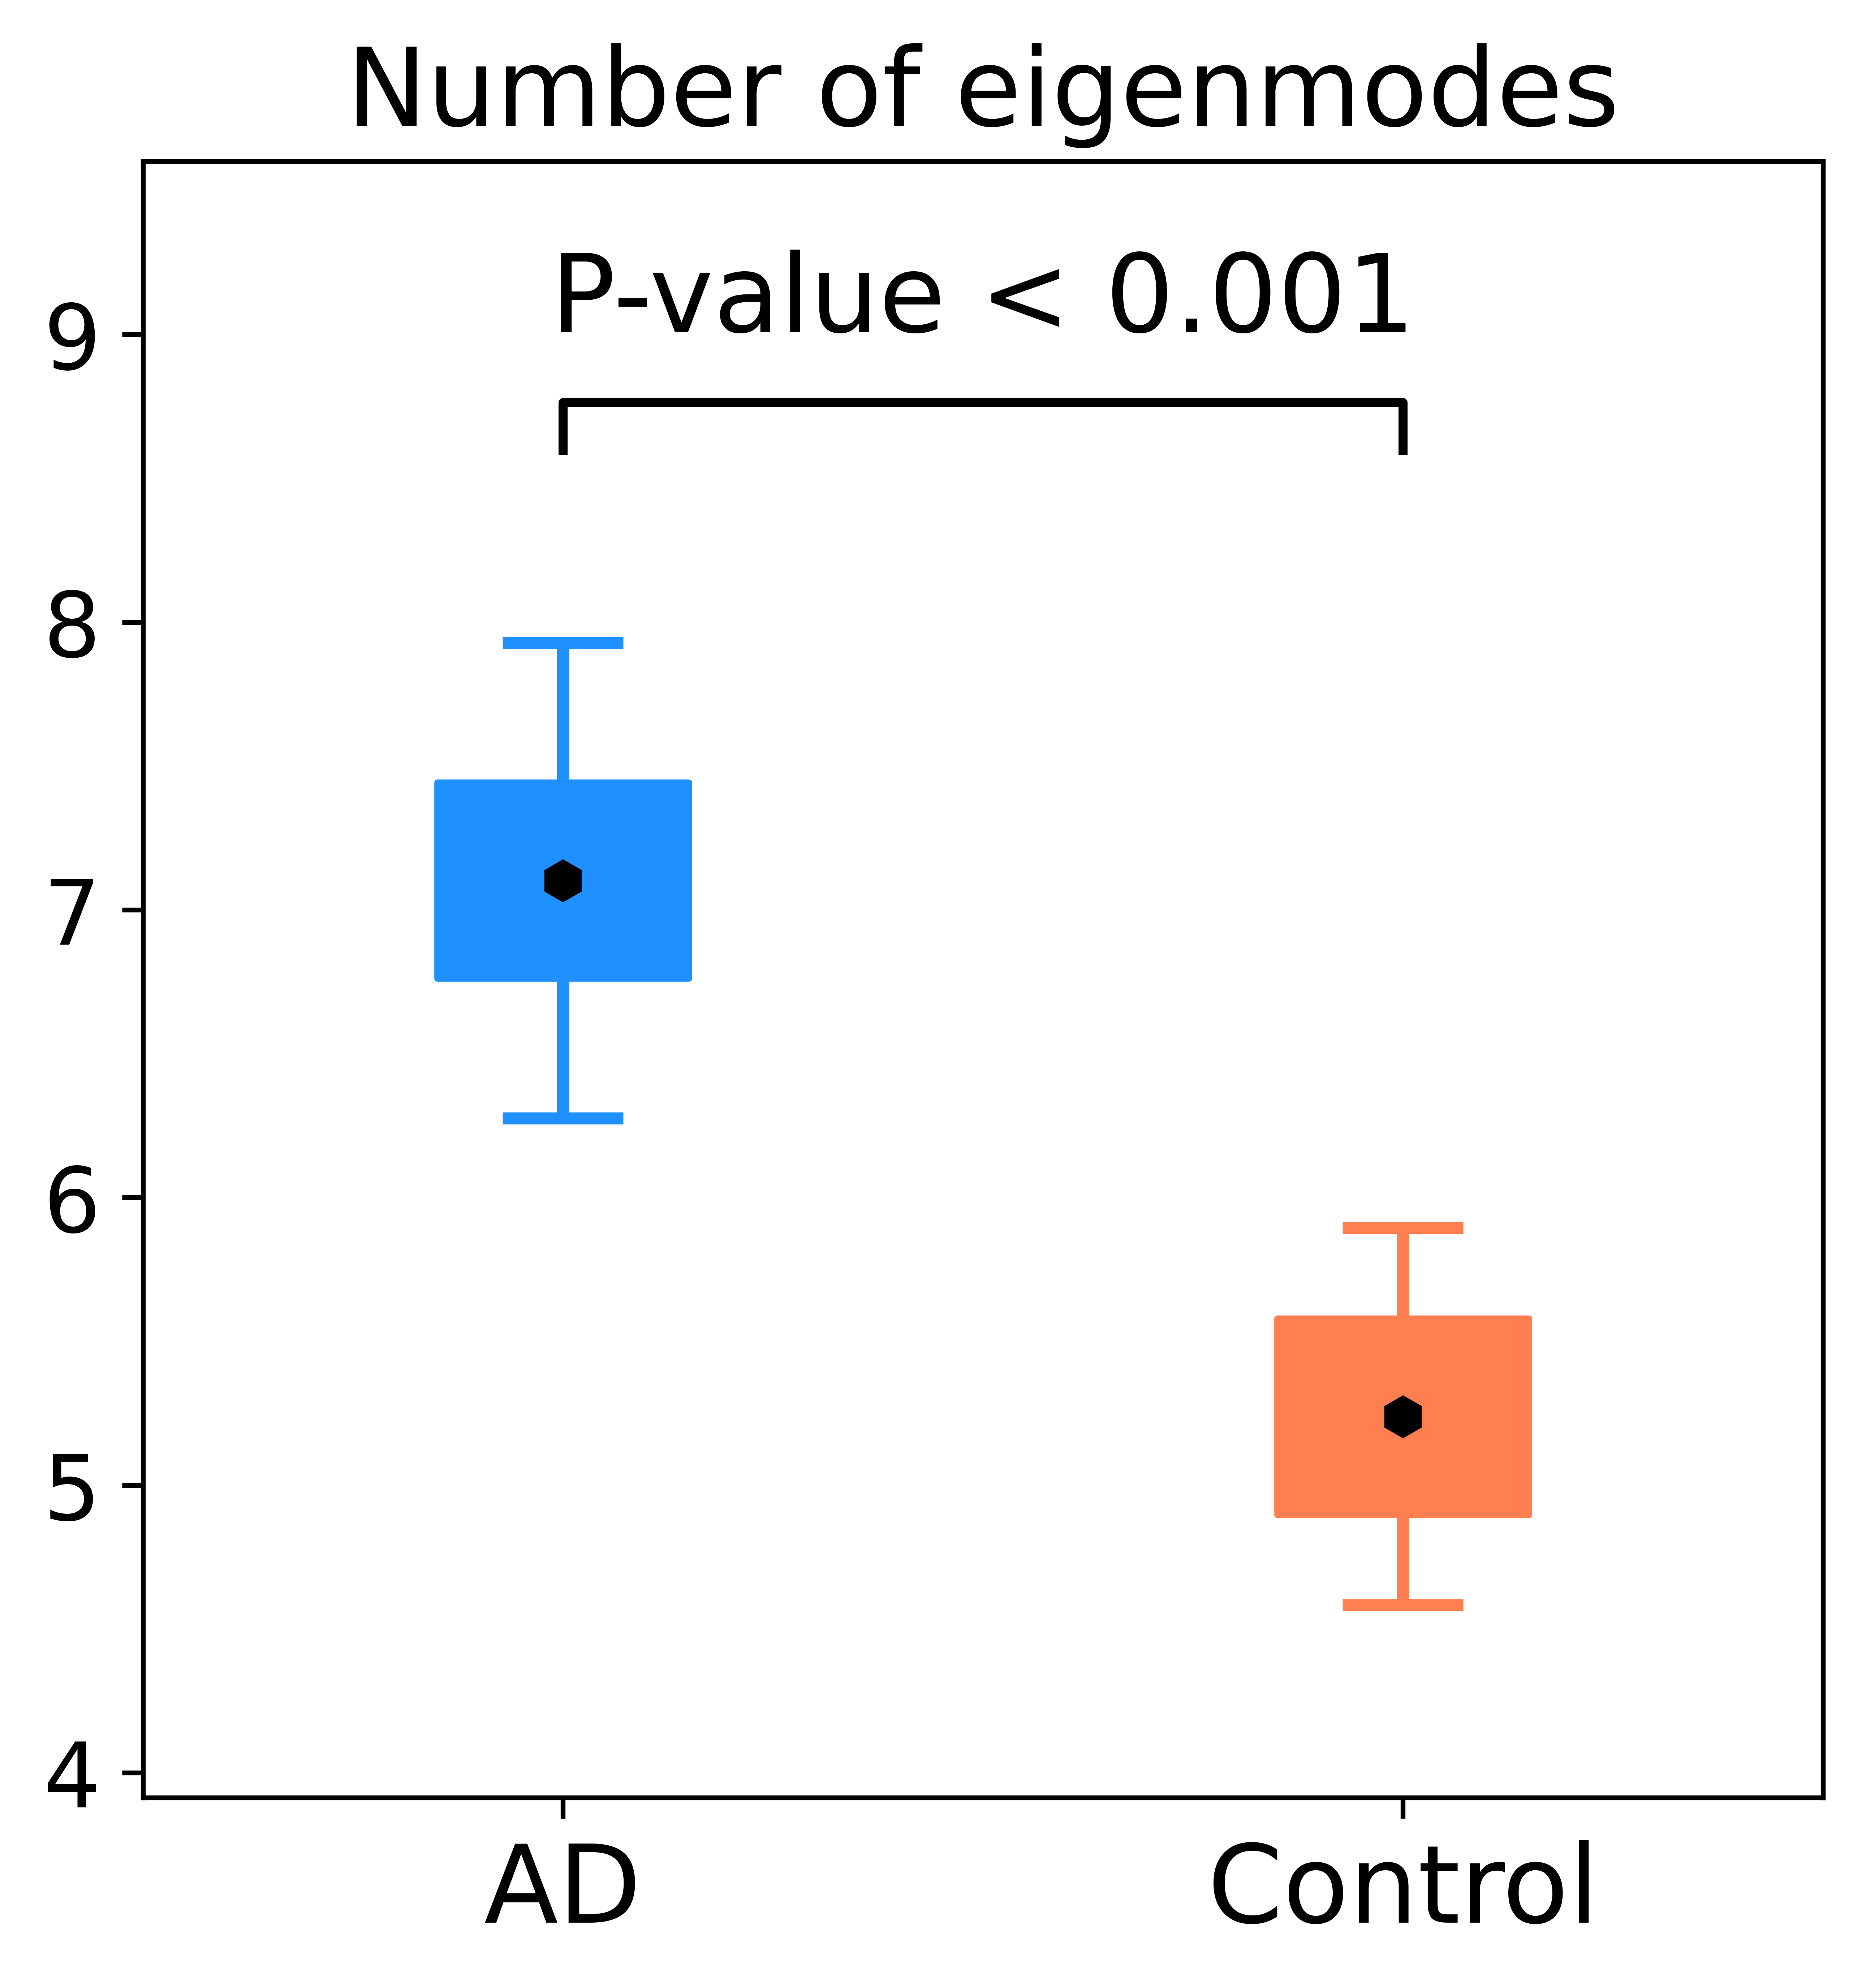

In [61]:
plt.figure(figsize=[5, 5], dpi=1200)
res = scipy.stats.ttest_ind(rksAD, rksCtrl, equal_var=False)
box_len = tmp_plot_bar2(fs=[rksAD, rksCtrl], pvalue=res.pvalue)
tmp_errbar_boxplot_wrap(rksAD, rksCtrl, box_len)
plt.yticks(fontsize=15)
plt.title("Number of eigenmodes", fontsize=18)
plt.savefig("./plots/errbarplot_rks.jpg", bbox_inches='tight')

In [ ]:
plt.figure(figsize=[5, 5], dpi=1200)
tmp_plot_base(rksAD, rksCtrl)
res = scipy.stats.ttest_ind(rksAD, rksCtrl, equal_var=False)
tmp_plot_bar(txty=13, bary=15, fs=[rksAD, rksCtrl], pvalue=res.pvalue, is_small=0)

plt.ylim([-1, 18])
plt.title("Number of eigenmodes")
plt.savefig("./plots/boxplot_rks.jpg", bbox_inches='tight')

### Max dwell time

In [63]:
maxdwell_AD = [fs.maxDwell for fs in fsAD]
maxdwell_Ctrl = [fs.maxDwell for fs in fsCtrl]

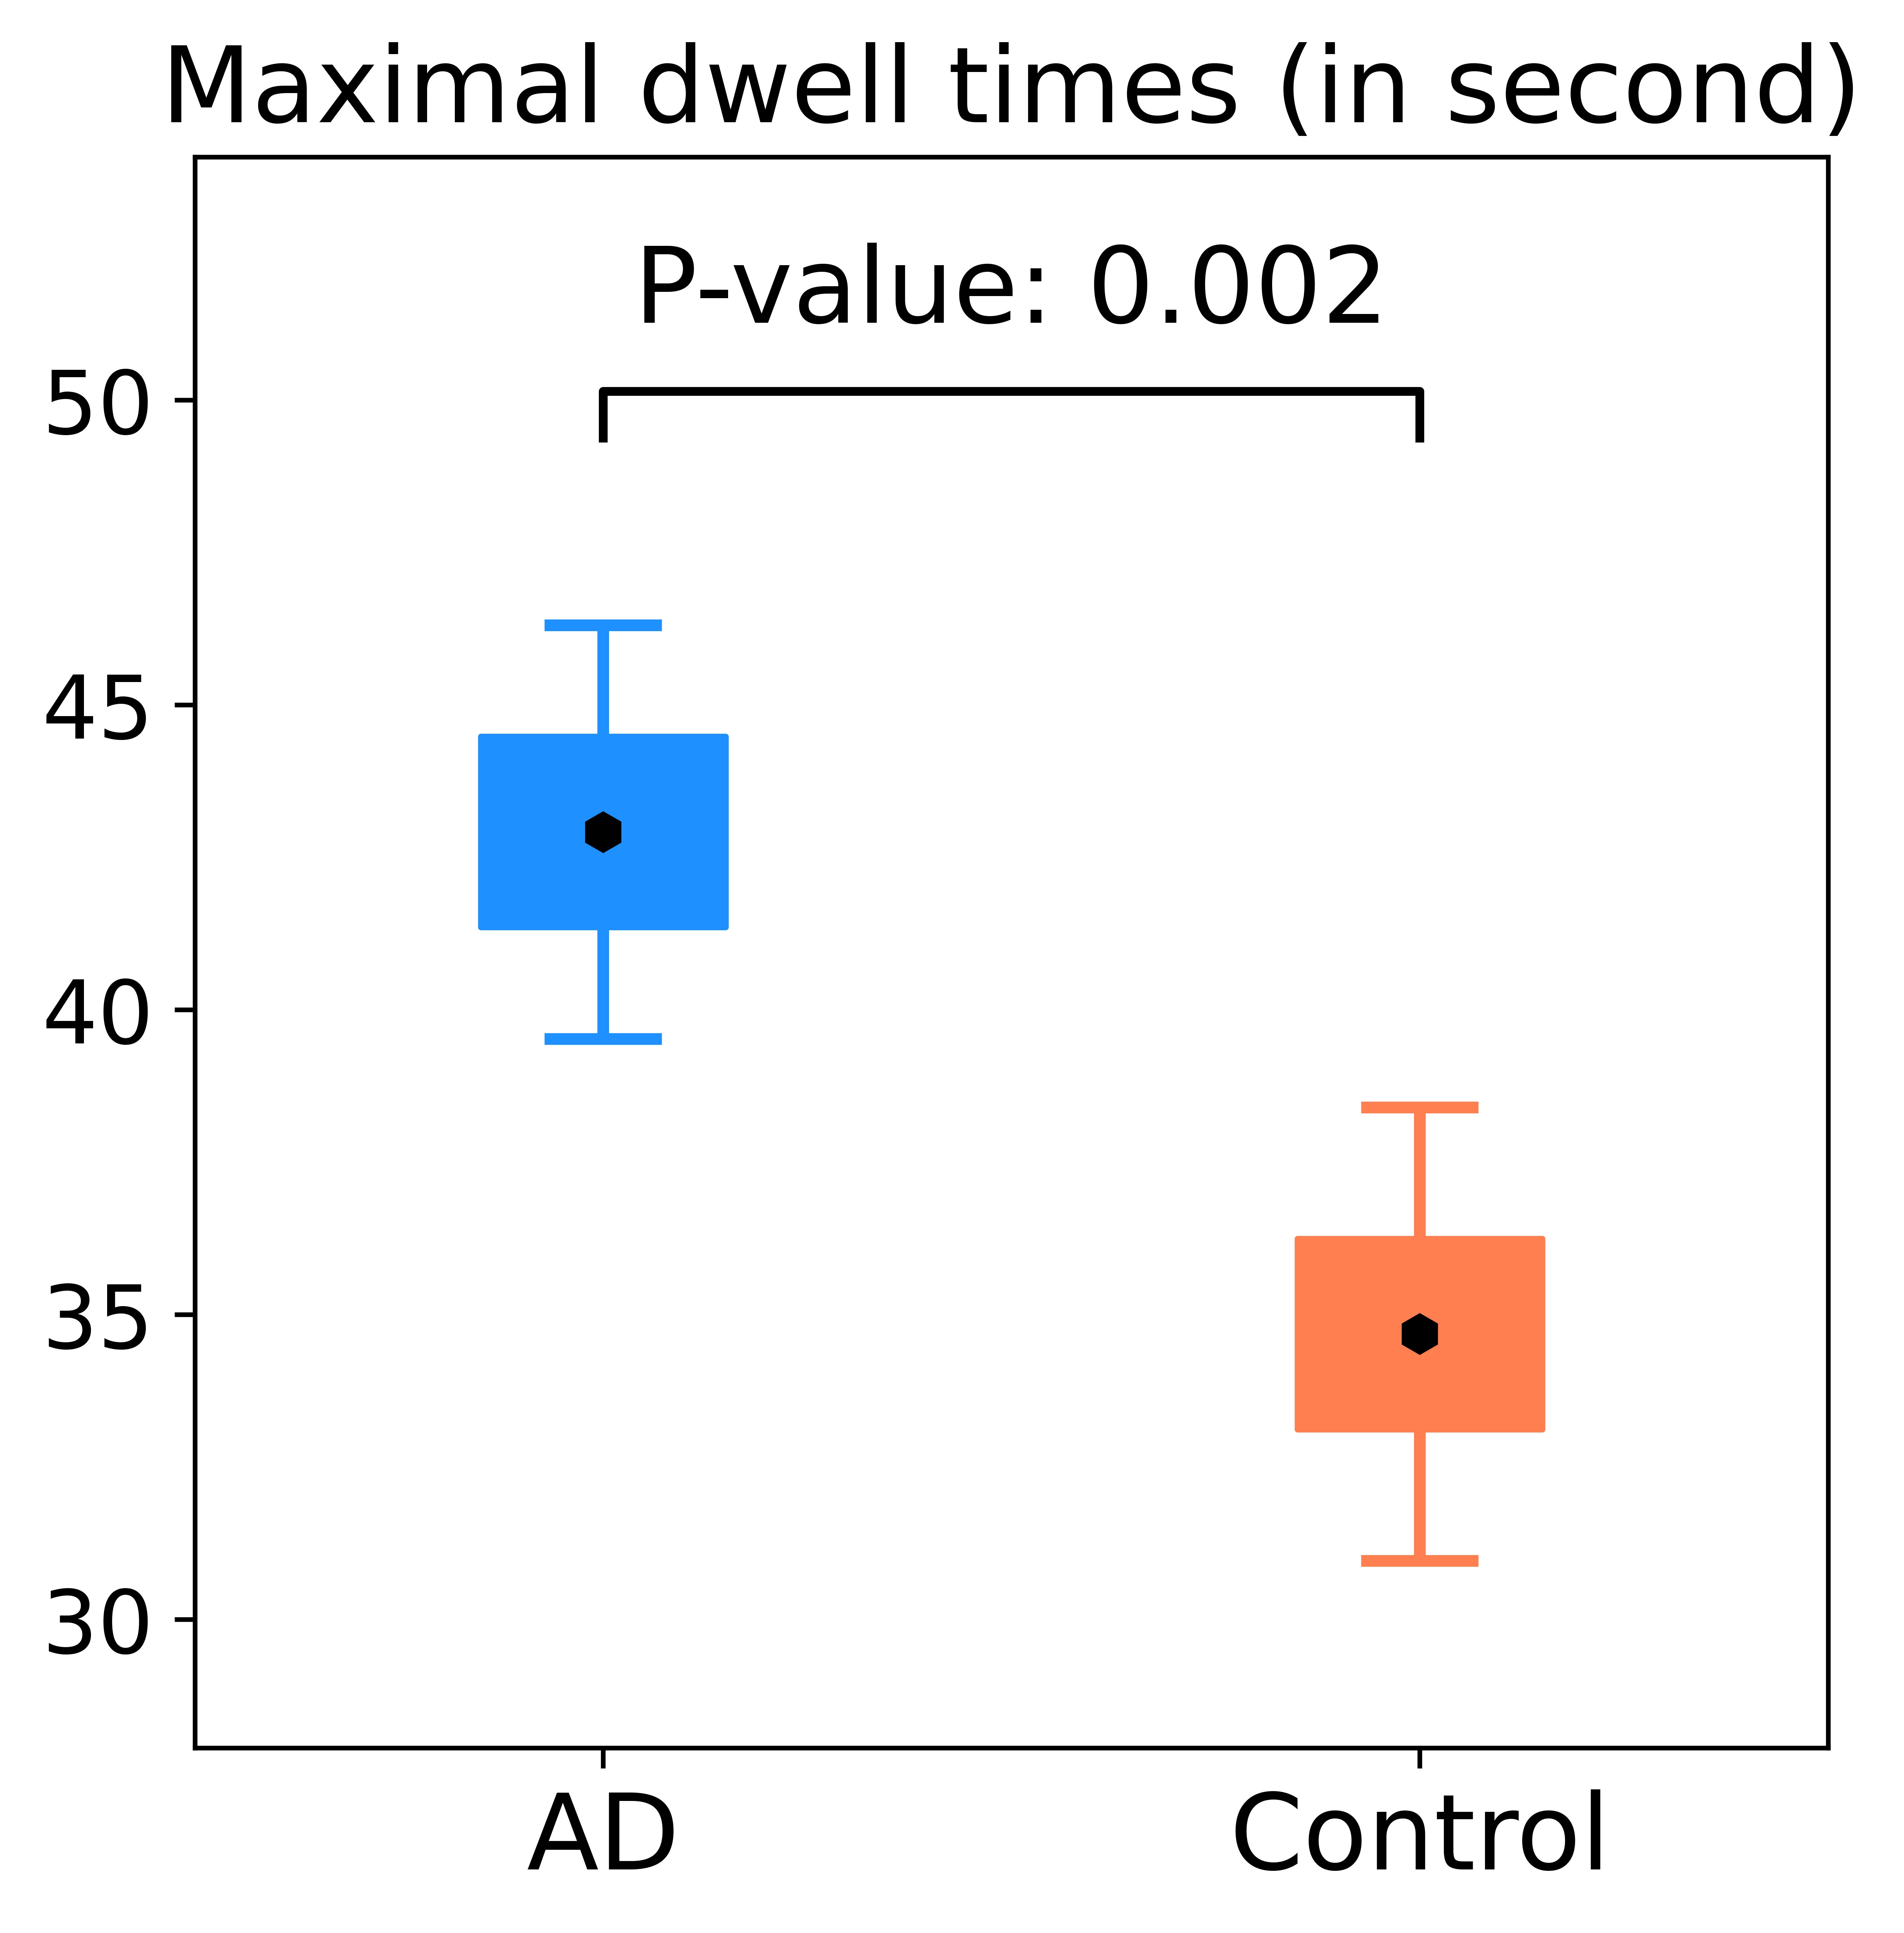

In [64]:
plt.figure(figsize=[5, 5], dpi=1200)
res = scipy.stats.ttest_ind(maxdwell_AD, maxdwell_Ctrl, equal_var=False)
box_len = tmp_plot_bar2(fs=[maxdwell_AD, maxdwell_Ctrl], pvalue=res.pvalue)
tmp_errbar_boxplot_wrap(maxdwell_AD, maxdwell_Ctrl, box_len)
plt.yticks(fontsize=15)
plt.title("Maximal dwell times (in second)", fontsize=18)
plt.savefig("./plots/errbarplot_maxDwellTimes.jpg", bbox_inches='tight')

In [ ]:
plt.figure(figsize=[5, 5], dpi=100)
tmp_plot_base(maxdwell_AD, maxdwell_Ctrl)
res = scipy.stats.ttest_ind(maxdwell_AD, maxdwell_Ctrl, equal_var=False)
tmp_plot_bar(txty=63, bary=70, fs=[maxdwell_AD, maxdwell_Ctrl], pvalue=res.pvalue, is_small=0)

plt.ylim([-1, 85])
plt.title("Maximal dwell times (in second)", fontsize=20)
#plt.savefig("./plots/boxplot_maxDwellTimes.jpg", bbox_inches='tight')

### ImagEig

In [93]:
abs_imag_eig_AD = [fs.absImagEigValMaxMean for fs in fsAD]
abs_imag_eig_Ctrl = [fs.absImagEigValMaxMean for fs in fsCtrl]
abs_imag_eig_AD = np.array(abs_imag_eig_AD)*4/2/np.pi
abs_imag_eig_Ctrl = np.array(abs_imag_eig_Ctrl)*4/2/np.pi

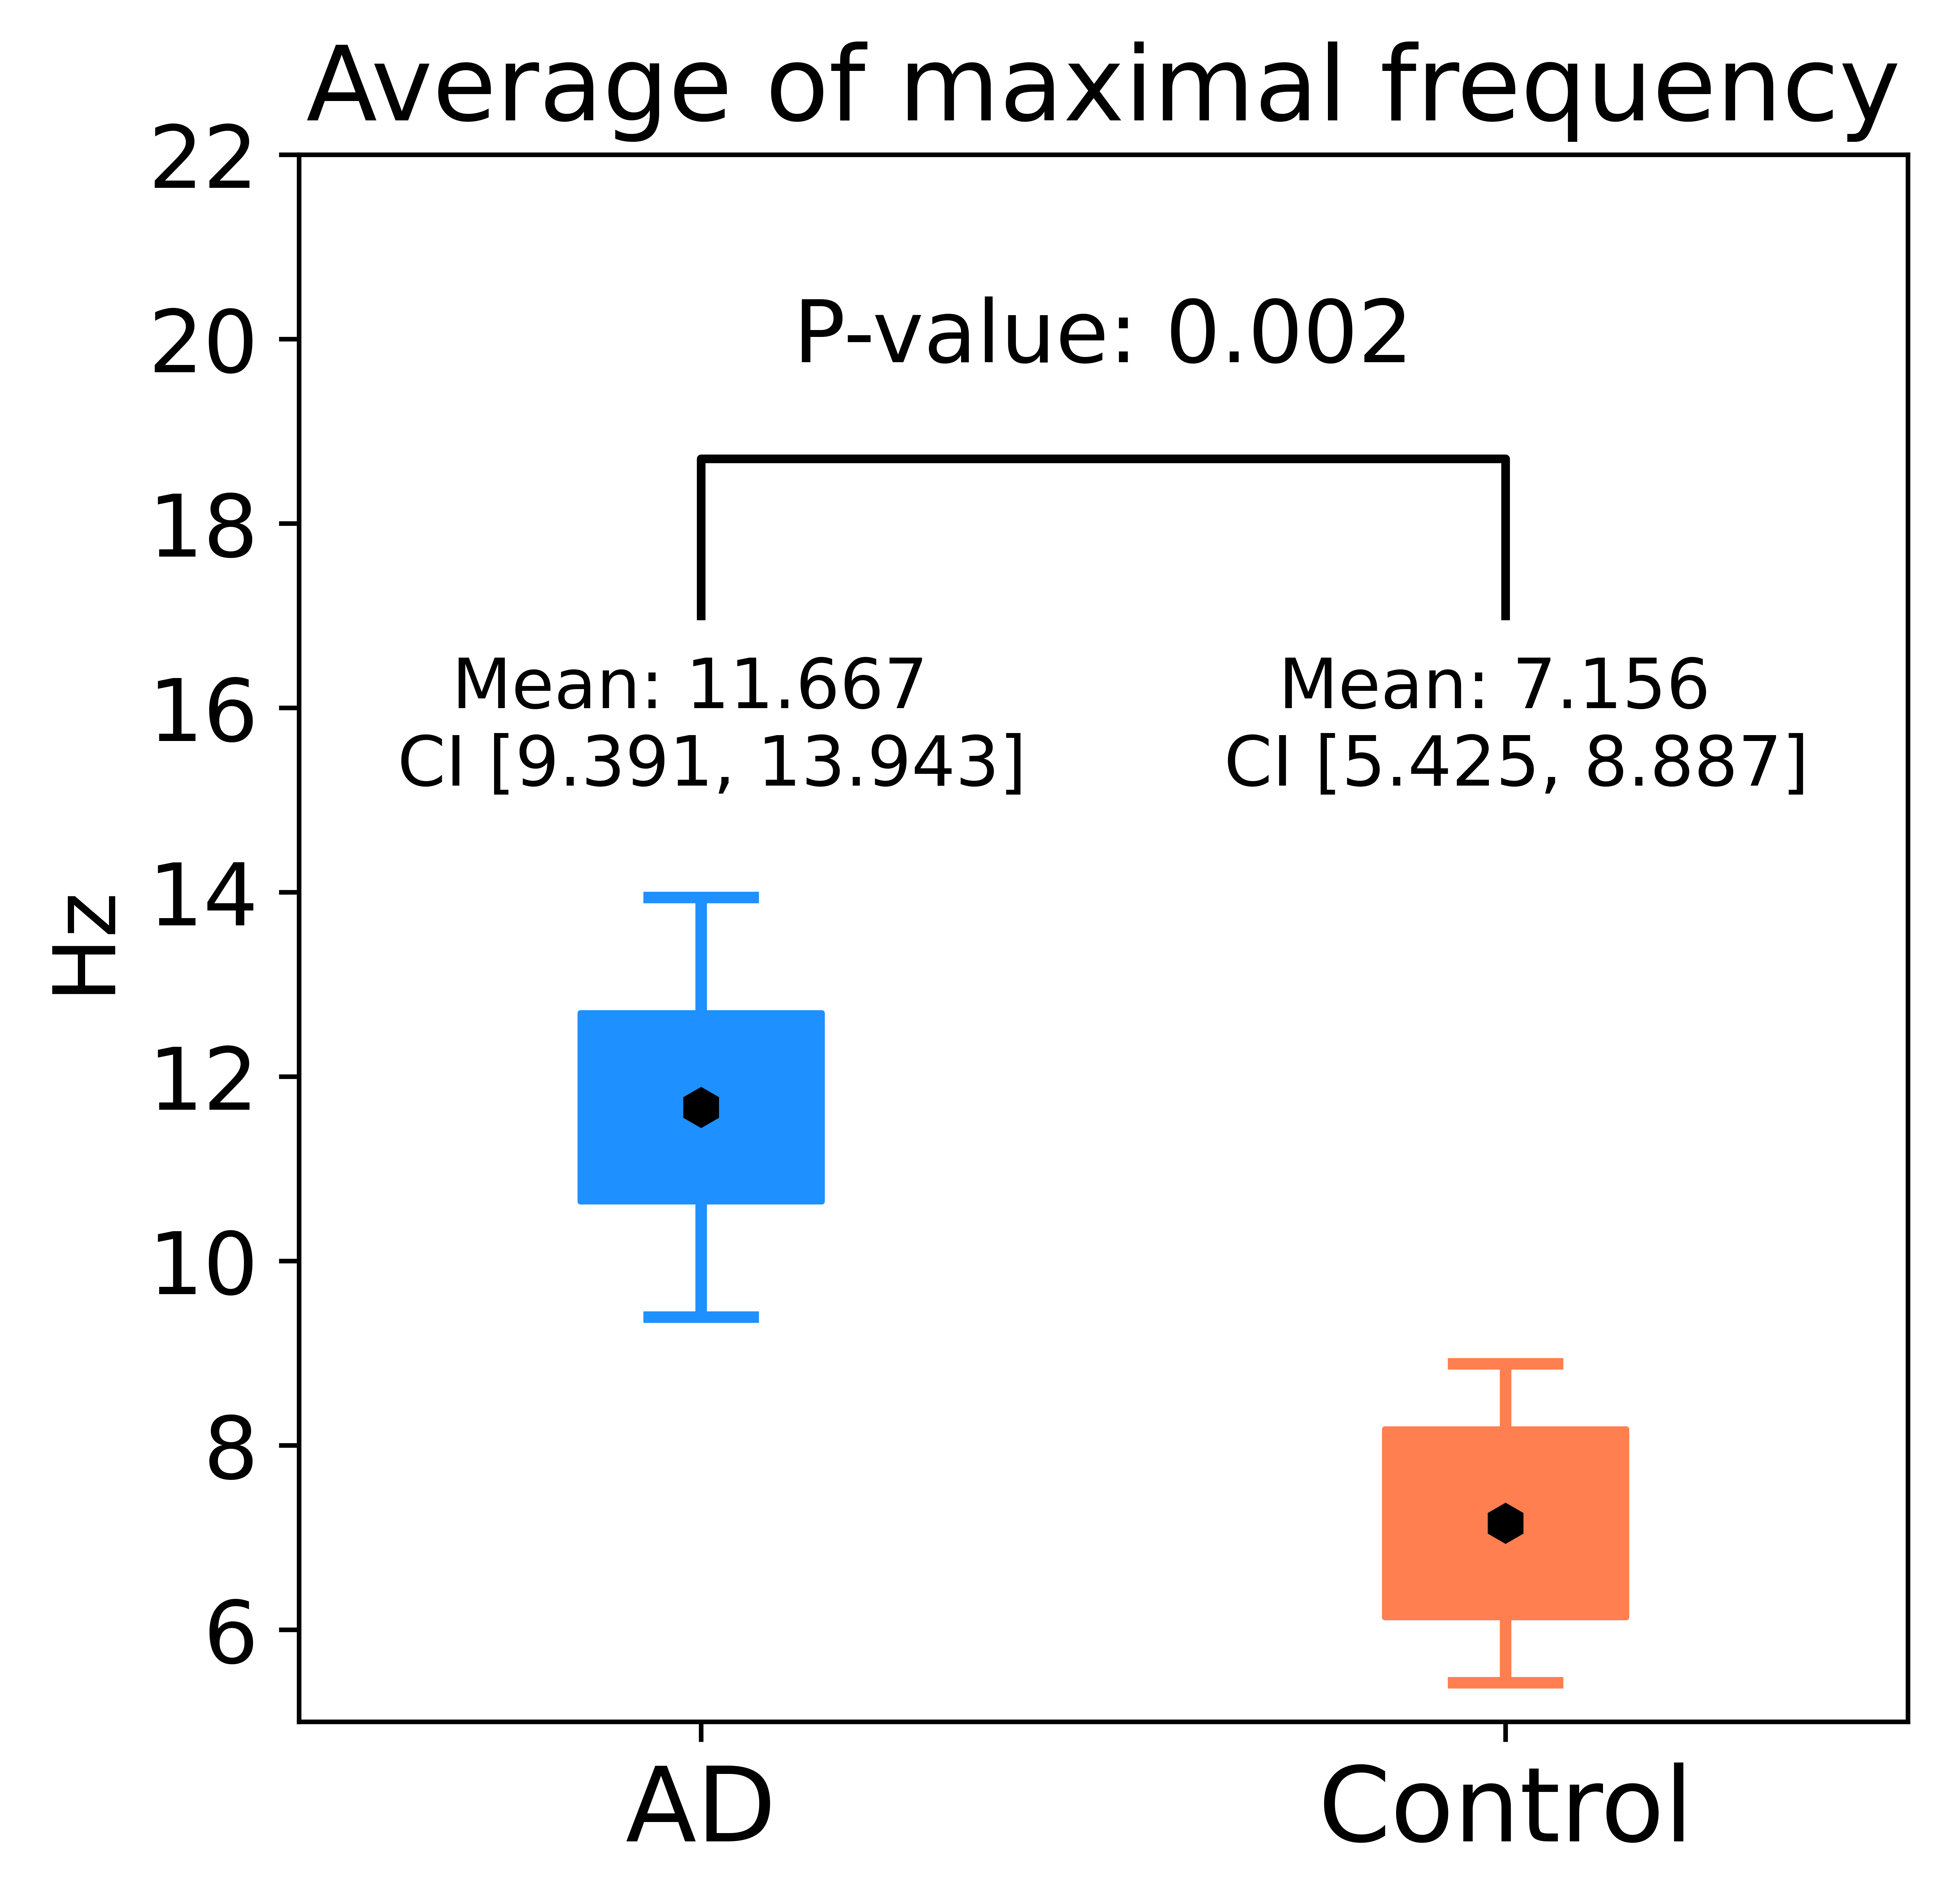

In [94]:
plt.figure(figsize=[5, 5], dpi=1200)
res = scipy.stats.ttest_ind(abs_imag_eig_AD, abs_imag_eig_Ctrl, equal_var=False)
tmp_errbar_boxplot_wrap(abs_imag_eig_AD, abs_imag_eig_Ctrl)
tmp_plot_bar2(txty=15, bary=17, fs=[abs_imag_eig_AD, abs_imag_eig_Ctrl], pvalue=res.pvalue)
plt.ylim([5, 22])
plt.yticks(fontsize=15)
plt.ylabel("Hz", fontsize=15)
plt.title("Average of maximal frequency", fontsize=18)
plt.savefig("./plots/errbarplot_abs_imag_eigval.jpg", bbox_inches='tight')

In [57]:
np.mean(abs_imag_eig_AD), CI95(abs_imag_eig_AD)

(11.66746566754336, [9.391487123477694, 13.943444211609025])

In [58]:
np.mean(abs_imag_eig_Ctrl), CI95(abs_imag_eig_Ctrl)

(7.155611131388332, [5.424715088500228, 8.886507174276435])

In [59]:
res.pvalue

0.002469609792246152